# Imports

In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce RTX 3090


In [2]:
from orbit_generation.constants import EM_MU
from orbit_generation.data import TSFeatureWiseScaler, create_dataloaders
from orbit_generation.processing import reorder_orbits
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits, export_dynamic_orbits_html
from orbit_generation.stats import plot_histograms_comparison
from orbit_generation.dataset import get_first_period_dataset, get_orbit_classes
from orbit_generation.model_factory import get_model
from orbit_generation.architectures import VAELossHistory
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment, add_experiment_metrics
from orbit_generation.evaluation import evaluate_clustering_multiple_labels, calculate_closest_feature_distances
from orbit_generation.latent_space import plot_2d_latent_space, plot_combined_2d_latent_space, plot_2d_latent_space_with_feature_distributions, reduce_dimensions_latent_space

In [3]:
import numpy as np
import os
from pytorch_lightning import Trainer

# Parameters

In [19]:
want_to_train = True   # Set this parameter to False if you want to load the model from the folder
want_to_generate = True    # Set this parameter to False if you want to load the generation from the folder
calculate_error_metrics = True   # Set this parameter to False if you don't want to calculate any metric
want_to_generate_latent_space = True    # Set this parameter to False if you don't wan't to generate the latent space
want_to_get_cluster_metrics = True    # Set this parameter to False if you want to load the generation from the folder
want_to_study_converged_orbits = True   # Set this parameter to False if you don't want to calculate any metric

In [5]:
data_path = r"/orbit-generation/data/orbits_fix_1500/EM_N_fix_1500.h5"
experiments_folder = "../experiments"

In [6]:
params = {
    'model_name': 'vae_conv5_legit',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 2,
    'feature_dim': 7,
    'seq_len': 100,
    'val_split': 0.05,
    'batch_size': 32,
    'epochs': 25,
    'beta': 10,
    'lr': 0.001,
    'dropout_rate': 0.2
}

# Data

## Import

In [7]:
data, orbit_df, labels, system_dict = get_first_period_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

(45211, 7, 100)

Remove the time variable if specified in params

In [8]:
if params['feature_dim']==6:
    data=data[:,1:,:]
    data.shape

## Scaling

In [9]:
scaler = TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(torch.tensor(data, dtype=torch.float32))
scaled_data.shape

torch.Size([45211, 7, 100])

# Modelling

In [ ]:
model = get_model(params)

In [10]:
if want_to_train:
    train_loader, val_loader = create_dataloaders(scaled_data, val_split=params.get('val_split', 0.1), batch_size=params.get('batch_size', 32))

    loss_history = VAELossHistory()

    trainer = Trainer(
        max_epochs=params.get('epochs', 10),
        log_every_n_steps=10,
        devices="auto",
        accelerator="auto",
        enable_progress_bar=True,
        enable_model_summary=True,
        callbacks=[loss_history]
    )

    trainer.fit(model, train_loader, val_loader)

    for metric_name, metric_value in trainer.callback_metrics.items():
        print(f"{metric_name}: {metric_value}")

    loss_history.plot_all_losses()

## Saving

In [14]:
experiment_folder = setup_new_experiment(params, experiments_folder)
images_folder = os.path.join(experiment_folder, 'images')
if not os.path.exists(images_folder):
    os.makedirs(images_folder)
experiment_id = os.path.basename(experiment_folder).split('_')[1]

New experiment setup complete: ../experiments/experiment_8
Parameters saved to ../experiments/experiments.json.


Define full paths for saving

In [15]:
generated_data_path = os.path.join(experiment_folder, f'exp{experiment_id}_generated_orbits.npy')
static_all_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_all_generated_orbits.png')
static_some_orbit_path = os.path.join(images_folder, f'exp{experiment_id}_some_generated_orbits.png')
dynamic_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_generated_orbits.html')
latent_representations_path = os.path.join(experiment_folder, f'exp{experiment_id}_latent_representations.npy')
model_save_path = os.path.join(experiment_folder, f'exp{experiment_id}_model.pth')
latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_latent_space')
converged_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_converged_orbits')
combined_latent_space_path = os.path.join(images_folder, f'exp{experiment_id}_combined_latent_space')
dynamical_refined_orbits_path = os.path.join(images_folder, f'exp{experiment_id}_refined_orbits.html')
model_losses_path = os.path.join(images_folder, f'exp{experiment_id}_model_losses.png')
histogram_comparison_path = os.path.join(images_folder, f'exp{experiment_id}_histogram_comparison.png')

In [16]:
if want_to_train:
    add_experiment_metrics(experiments_folder, params=params, metrics=trainer.callback_metrics)
    torch.save(model.state_dict(), model_save_path)
else:
    model.load_state_dict(torch.load(model_save_path))    

## Generate

In [20]:
if want_to_generate:
    # Generate the orbits
    num_samples=100
    generation = model.sample(num_samples)
    generation = scaler.inverse_transform(generation)
    np.save(generated_data_path, generation.detach().numpy())
else:
    # Load the orbits
    generation = np.load(generated_data_path)

generation.shape

torch.Size([100, 7, 100])

# Analysis of Generation

## Visualization

In [21]:
if generation.shape[1] == 7:
    no_time_generation = generation[:,1:,:].detach().numpy()
    generation.shape
else:
    no_time_generation = generation.cpu().numpy()

no_time_generation.shape

(100, 6, 100)

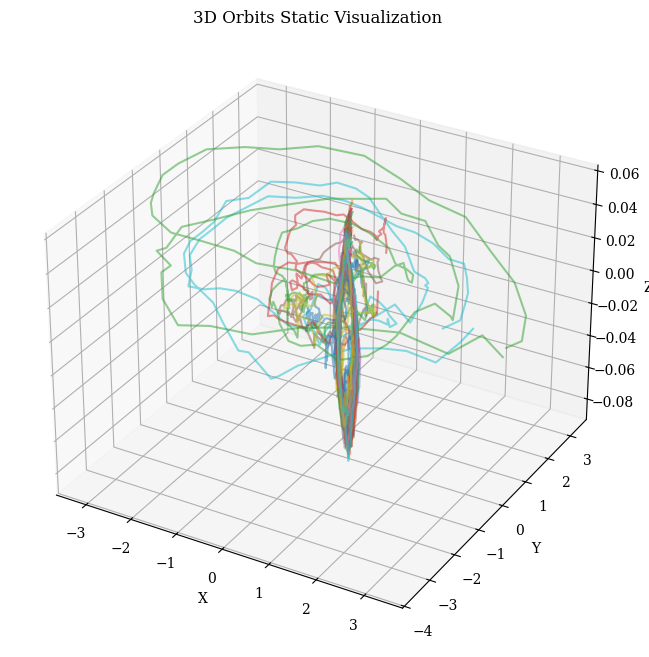

In [22]:
visualize_static_orbits(data= no_time_generation, show_legend=False, save_path=static_all_orbit_path)

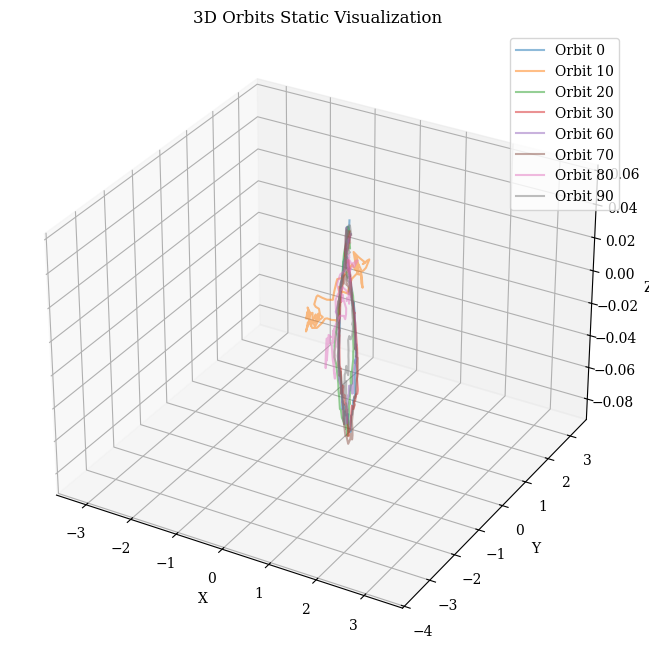

In [23]:
visualize_static_orbits(data= no_time_generation, orbit_indices=[0,10,20,30,60,70,80,90], save_path=static_some_orbit_path)

In [24]:
export_dynamic_orbits_html(data=no_time_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment_8/images/exp8_generated_orbits.html


## Coverage

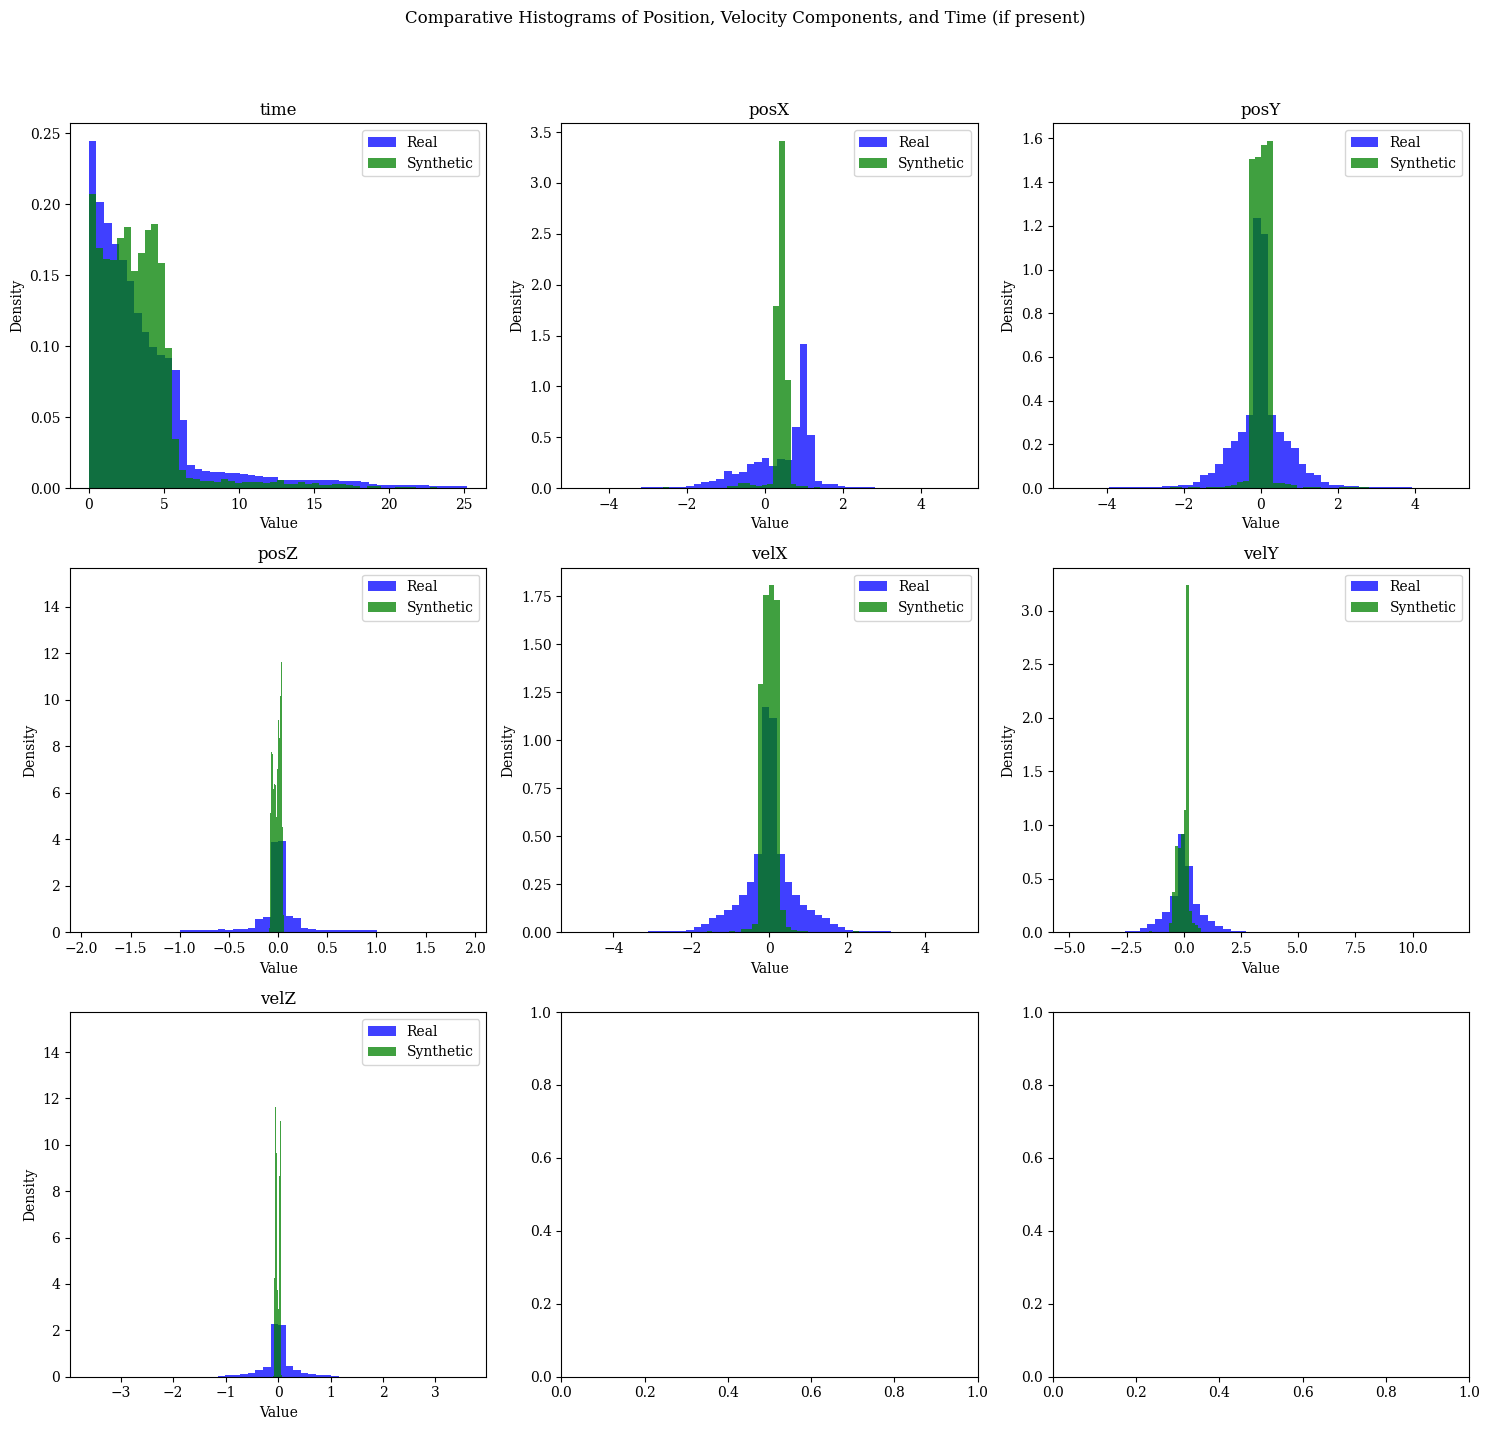

In [25]:
plot_histograms_comparison(data1=data, data2=generation.detach().numpy(), label1='Real', label2='Synthetic', normalize=True, save_path=histogram_comparison_path)

## Pheasibility

Cumulative position error for selected orbits: 600.631881243094
Average position error per time step: 6.066988699425192


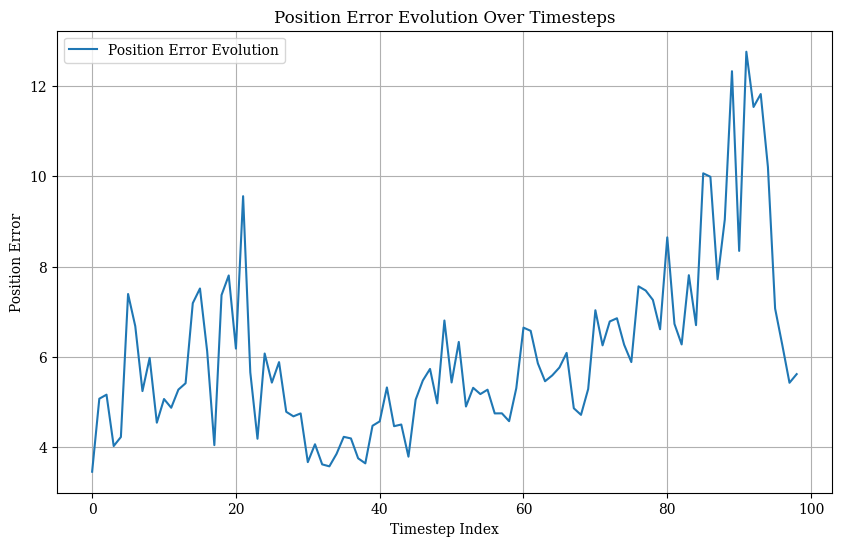

Cumulative velocity error for selected orbits: 3453.3007272452314
Average velocity error per time step: 34.88182552772961


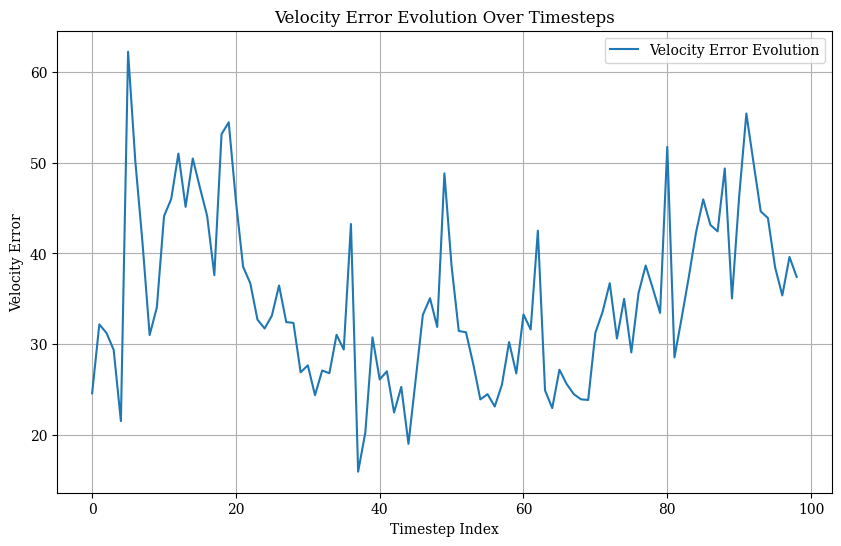

Cumulative energy error for selected orbits: 7016.74951171875
Average energy error per time step: 70.87625885009766


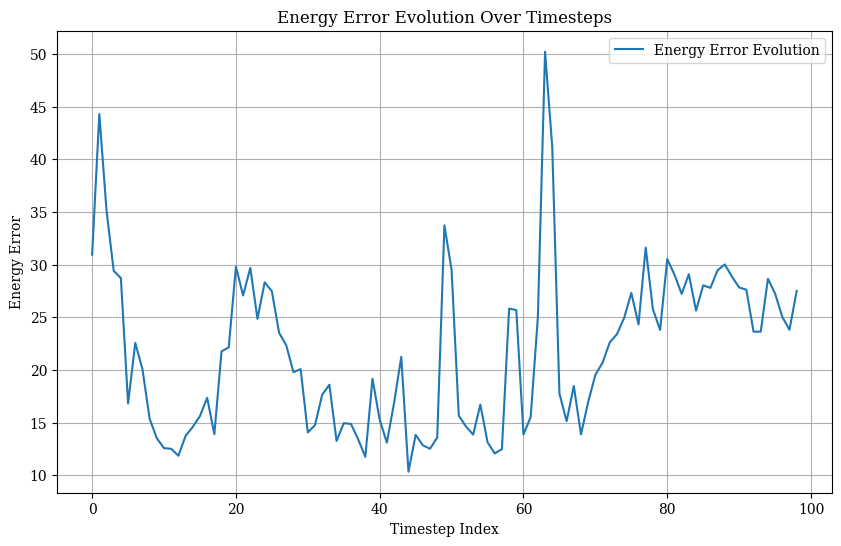

Metrics added to experiment with ID 8 in ../experiments/experiments.json.


In [26]:
if calculate_error_metrics:
    reordered_orbits, order_metrics = reorder_orbits(generation.detach().numpy())
    errors = calculate_errors(reordered_orbits,EM_MU)
    add_experiment_metrics(experiments_folder, params=params, metrics={**errors, **order_metrics})

# Latent Space

In [30]:
latent_mean, latent_log_var = model.encode(scaled_data)
latent_mean = latent_mean.detach().numpy()
latent_representation = np.concatenate((latent_mean, latent_log_var.detach().numpy()), axis=1)
np.save(latent_representations_path, latent_representation)
latent_representation.shape

(45211, 4)

In [31]:
orbits_id_classes = [orbit_df.at[index, 'id_class'] for index in labels]
family_labels=get_orbit_classes(orbits_id_classes)[0]

feature_names=['jacobi', 'period', 'stability']
features=orbit_df[feature_names].to_numpy()

## Visualize

In [29]:
latent_mean.shape

(45211, 2)

Saved plot to ../experiments/experiment_8/images/exp8_latent_space


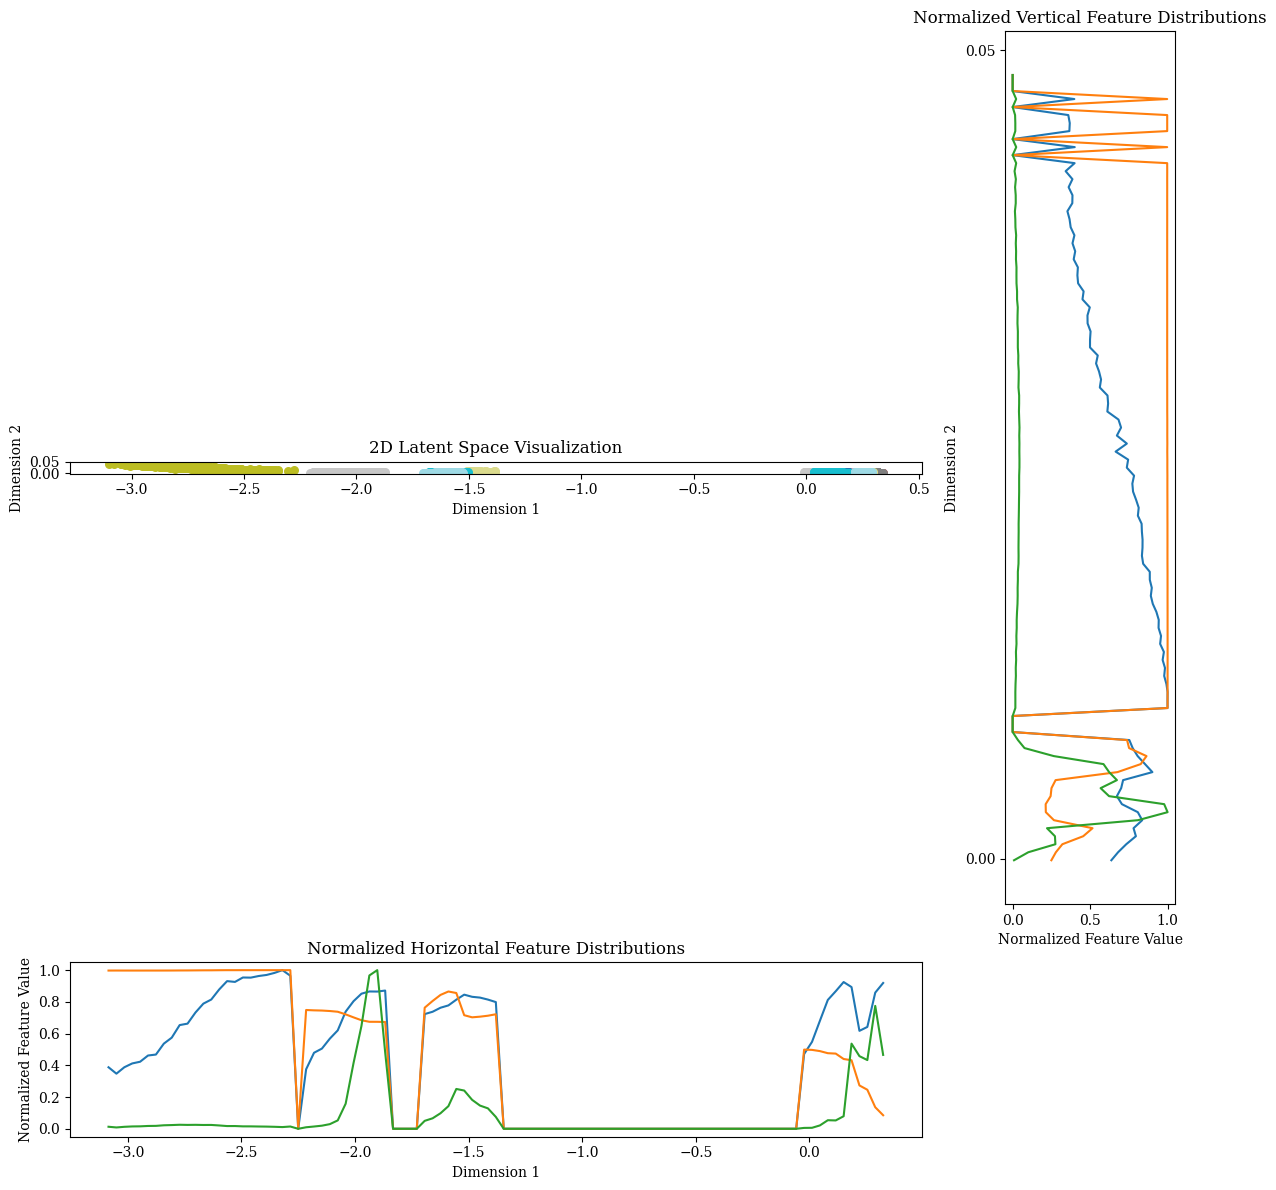

In [33]:
if want_to_generate_latent_space:
    if latent_mean.shape[1]==2:
        plot_2d_latent_space_with_feature_distributions(latent_mean, np.array(family_labels), save_path=latent_space_path,
                                                    many_classes=False, features=features, feature_names=feature_names, show_legend=False, legend_fontsize=8.25)
    else:
        reduce_dimensions_latent_space(latent_mean, np.array(family_labels),techniques=['PCA','UMAP','t-SNE'], save_path=latent_space_path,show_legend=False)


## Clustering

|||| change clases

In [ ]:
if want_to_get_cluster_metrics:
    cluster_metrics = evaluate_clustering_multiple_labels(latent_mean, orbits_id_classes, label_names=['label','type','subtype','direction'], clustering_method='gmm')
    add_experiment_metrics(experiments_folder, params=params, metrics=cluster_metrics)

# Convergence

In [ ]:
### make it converge and obtain refined_orbits

In [ ]:
# visualize_static_orbits(refined_data[:,:,1:], show_legend=False, save_path=converged_orbits_path)

In [ ]:
# export_dynamic_orbits_html(refined_data[:,:,1:], filename=dynamical_refined_orbits_path)

## Metrics

In [ ]:
generated_scaled_data = scaler.transform(refined_data)
generation_latent_mean, generation_latent_log_var = model.encode(generated_scaled_data)
generation_latent_representations = latent_mean.numpy()
generation_latent_representations.shape

CHANGE!!!

In [ ]:
if want_to_study_converged_orbits:
    non_matching_elements = find_non_matching_elements(latent_representation, generation_combined_latent_representation)
    convergence_metrics = {'percentage_convergence':len(generated_data)/100 ,'percentage_novelty':len(non_matching_elements)/len(generated_data)*100 , 'average_iterations_convergence':df['iterations_convergence'].mean()}
    add_experiment_metrics(experiments_folder, params=params, metrics=convergence_metrics)

## Latent Space

In [ ]:
if want_to_study_converged_orbits:
    if latent_mean.shape[1]==2:
        plot_combined_latent_space_2d(
            real_data=scaled_data, 
            synthetic_data=generated_scaled_data, 
            encoder=encoder, 
            synthetic_labels=list(range(0, len(generated_scaled_data))),
            annotation_mode='numbers',
            save_path=combined_latent_space_path,
            show_legend=True
        )
    else:
        reduce_dimensions_plot_combined_latent_space(
            real_data=scaled_data, 
            synthetic_data=generated_scaled_data, 
            encoder=encoder,
            techniques=['PCA','UMAP','t-SNE'],
            save_path=combined_latent_space_path
        )

## Check Novelty

Calculate Jacobi Constant on the dataset

In [ ]:
### array should be (45211, 300, 6)

In [ ]:
results = np.array([jacobi_constant(full_data[i][0], EM_MU)[0] for i in range(full_data.shape[0])])
orbit_df['calculated_jacobi'] = results

orbit_df.head()

Calculate Jacobi Constant and Period on the Refined Orbits

In [ ]:
new_jacobis = np.array([jacobi_constant(display_generation[i][0], EM_MU)[0] for i in range(display_generation.shape[0])])
synthetic_orbit_df['calculated_jacobi'] = new_jacobis
synthetic_orbit_df.rename(columns={'new_period': 'period'}, inplace=True)

synthetic_orbit_df.head()

Compare

In [ ]:
# Define the features to be used for distance calculation
features = ['period', 'calculated_jacobi']

# Calculate the distances
distances = calculate_closest_feature_distances(orbit_df, synthetic_orbit_df, features)

In [ ]:
distances